In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "./chest_xray/"
sz=224
arch=dn121
bs=32

In [3]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [4]:
os.listdir(f'{PATH}valid')

['PNEUMONIA', 'NORMAL']

In [5]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [6]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.178576   0.588315   0.791667  
    1      0.112696   0.665418   0.814103                  
    2      0.083435   0.664182   0.814103                   



[array([0.66418]), 0.8141025656308883]

In [7]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.067927   0.671753   0.8125    
    1      0.064032   0.718383   0.810897                   
    2      0.05754    0.705057   0.822115                   



[array([0.70506]), 0.8221153861437088]

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [9]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [10]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.148184   0.586872   0.823718  
    1      0.100081   0.709545   0.817308                     
    2      0.091606   0.782801   0.80609                      
    3      0.095286   0.802757   0.801282                     
    4      0.067125   0.770694   0.830128                     



[array([0.77069]), 0.8301282051282052]

In [11]:
learn.precompute=False

In [12]:
learn.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.11824    0.496045   0.870192  



[array([0.49605]), 0.8701923076923077]

In [13]:
learn.unfreeze()

In [14]:
lr=np.array([1e-4,1e-3,1e-2])

In [15]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.106142   0.404625   0.878205  
    1      0.107309   0.273193   0.916667                    
    2      0.086851   0.279926   0.918269                     
    3      0.08789    0.355247   0.894231                     
    4      0.073295   0.463375   0.879808                     
    5      0.07357    0.409282   0.899038                     
    6      0.04994    0.334547   0.913462                     



[array([0.33455]), 0.9134615384615384]

In [16]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [17]:
accuracy_np(probs, y)

0.875

## Performance Matrix

In [18]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[158  76]
 [  2 388]]


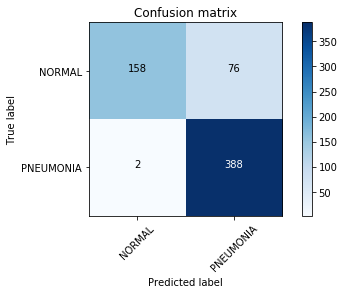

In [20]:
plot_confusion_matrix(cm, data.classes)

In [27]:
m = arch(True)

In [28]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [29]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [76]:
data.val_ds

In [30]:
learn = ConvLearner.from_model_data(m, data)

In [31]:
learn.freeze_to(-4)

In [32]:
m[-1].trainable

True

In [33]:
m[-4].trainable

True

In [34]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.337995   0.463759   0.737179  



[array([0.46376]), 0.7371794871794872]

In [35]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.257944   0.437465   0.769231  



[array([0.43747]), 0.7692307692307693]

### CAM

In [21]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [92]:
# x, y = next(iter(data.trn_dl))

In [109]:
x,y = next(iter(data.val_dl))

In [110]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

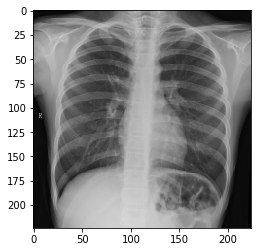

In [111]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [112]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [113]:
%time py = m(Variable(x.cuda()))

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.8 ms


In [114]:
for o in sfs: o.remove()

In [115]:
[o.features.size() for o in sfs]

[torch.Size([1, 256, 14, 14]),
 torch.Size([1, 1024, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [116]:
py = np.exp(to_np(py)[0]); py

array([0.39758, 0.60242], dtype=float32)

In [117]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [118]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.18348, 0.28073, 0.28943, 0.30764, 0.35926, 0.42985, 0.29934],
       [0.25098, 0.27362, 0.05492, 0.05037, 0.11782, 0.43224, 0.40523],
       [0.15995, 0.04892, 0.63229, 0.7999 , 0.52065, 0.06663, 0.21569],
       [0.05282, 0.20442, 0.79988, 1.     , 0.83443, 0.25786, 0.02085],
       [0.05891, 0.1847 , 0.61271, 0.87733, 0.80828, 0.48445, 0.13955],
       [0.02715, 0.04397, 0.47812, 0.88762, 0.75166, 0.51345, 0.08636],
       [0.     , 0.02653, 0.43377, 0.70354, 0.53663, 0.31952, 0.04284]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


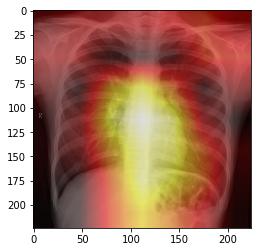

In [119]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), y)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plot_roc(preds,y)